We use the recursive Hermite polynomial defintion 
$$
He_0(x)=1, \qquad He_1(x)=x, \qquad He_k(x) = x He_{k-1}(x) - (k-1) He_{k-2}(x)
$$
and normalized Hermite 
$$
he_k(x) = \frac{1}{\sqrt{k!}}He_k(x) 
$$
**Orthogonality of Hermite polynomials:**
$$
E_{X\sim N(0,1)} [He_k(X) He_l(x)]= k! \delta_{kl},\qquad 
E_{X\sim N(0,1)} [he_k(X) he_l(x)]= \delta_{kl}
$$
where $\delta$ is Dirac delta, and also its normalized version. 

*Expansion in Hermite basis:* Based on orthognoality, we can expand in the normalized basis as 
$$
f(x) = \sum_{k=0}^\infty c_k he_k(x), \qquad c_k = E_{X\sim N(0,1)}f(X)he_k(X)
$$
and not normalized basis as 
$$
f(x) = \sum_{k=0}^\infty c_k He_k(x), \qquad c_k = \frac{1}{k!} E_{X\sim N(0,1)}f(X)He_k(X) 
$$



In [226]:
from functools import lru_cache
from numba import njit 
import numpy as np
import matplotlib.pyplot as plt


def get_activation_function(name):
    """
    Returns the activation function based on the provided name.

    Parameters:
    name (str): The name of the activation function. 
                Options are 'relu', 'sigmoid', 'tanh', 'softmax', 'linear', 
                'leaky_relu', 'elu', 'selu', 'celu', 'gelu', 'swish'.

    Returns:
    function: A function that computes the specified activation.

    Example use:
    
    f = get_activation_function('relu',)
    coefs = compute_hermite_coefs(f, coefs_len=20)
    f2 = hermite_expansion(coefs)
    print(coefs)
    x = np.linspace(-3,3,100)
    """
    @njit
    def relu(x):
        return np.maximum(0, x)
    @njit
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    @njit
    def tanh(x):
        return np.tanh(x)
    @njit
    def exp(x):
        return np.exp(x)
    @njit
    def softmax(x):
        exps = np.exp(x)
        return exps / np.sum(exps, axis=-1, keepdims=True)
    @njit
    def linear(x):
        return x
    @njit
    def leaky_relu(x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)
    @njit
    def elu(x, alpha=1.0):
        return np.where(x >= 0, x, alpha * (np.exp(x) - 1))
    
    @njit
    def selu(x, alpha=1.67326, scale=1.0507):
        return scale * np.where(x >= 0, x, alpha * (np.exp(x) - 1))
    @njit
    def celu(x, alpha=1.0):
        return np.where(x >= 0, x, alpha * (np.exp(x / alpha) - 1))
    @njit
    def gelu(x):
        return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))
    @njit
    def swish(x, beta=1.0):
        return x / (1 + np.exp(-beta * x))
    
    activations = {
        'relu': relu,
        'sigmoid': sigmoid,
        'tanh': tanh,
        'exp': exp,
        'softmax': softmax,
        'linear': linear,
        'leaky_relu': leaky_relu,
        'elu': elu,
        'selu': selu,
        'celu': celu,
        'gelu': gelu,
        'swish': swish
    }
    
    return activations.get(name.lower(), None)

@lru_cache(maxsize=1000)
def factorial(k):
    assert k >= 0 and k == int(k)
    if k<=1:
        return 1
    return k * factorial(k-1)

def coefs_derivative(coefs, r):
    if r == 0:
        return coefs
    coefs = coefs.copy()
    # print(f'derivative 0 = ', ', '.join(f"c{i}={c}" for i,c in enumerate(coefs)))
    for i in range(r):
        for k in range(1,len(coefs)):
            coefs[k-1] = k * coefs[k]
        coefs[len(coefs)-1-i] = 0
        # print(f'derivative {i+1} = ', ', '.join(f"c{i}={c}" for i,c in enumerate(coefs)))
    return coefs

def coefs_to_poly(coefs):
    @njit
    def f(x):
        K = len(coefs)
        x_powers = np.zeros((K,len(x)),dtype=np.float64)
        for i in range(K):
            x_powers[i] = x**i
        return coefs @ x_powers
    return f

def hermite_poly_coefs(k):
    if k == 0:
        return np.array([1,])
    elif k == 1:
        return np.array([0,1])
    else:
        H_k_minus_1 = hermite_poly_coefs(k-1)
        H_k_minus_2 = hermite_poly_coefs(k-2)
        return np.concatenate([[0], H_k_minus_1]) - (k-1) * np.concatenate([H_k_minus_2, [0, 0]])

def hermite_poly_coefs_norm(k):
    coefs = hermite_poly_coefs(k)
    c = factorial(k)**0.5
    return coefs / c

def hermite_expansion(coefs, norm=True, return_coefs=False):
    K = len(coefs)
    cs = np.zeros(len(coefs),dtype=np.float64)
    for k,c in enumerate(coefs):
        if norm:
            cs += c * np.concatenate([hermite_poly_coefs_norm(k), np.zeros(K-1-k)])
        else:
            cs += c * np.concatenate([hermite_poly_coefs(k), np.zeros(K-1-k)])
    if return_coefs:
        return coefs_to_poly(cs), cs
    return coefs_to_poly(cs)

def hermite_poly(k,norm=True):
    coefs = np.zeros(k+1,dtype=np.float64)
    coefs[k] = 1
    return hermite_expansion(coefs, norm=norm)

@lru_cache(maxsize=1000)
def compute_hermite_coefs(f, order, norm=True, num_samples=10**7):
    X = np.random.randn(num_samples)
    hermite_coefs = np.zeros(order)
    for k in range(len(hermite_coefs)):
        hermite_coefs[k] = np.mean(f(X) * hermite_poly(k,norm=norm)(X))
        if not norm:
            hermite_coefs[k] /= factorial(k)
    return hermite_coefs


# test orthogonality of polynomials 
def test_orthogonality(K=4, eps = 1e-2):
    X = np.random.randn(10**7)
    for norm in [True, False]:
        poly_name = "he" if norm else "He"
        print(f"Testing orthogonality of {"normalized" if norm else ""} Hermite polynomials ({poly_name}(x))")
        for k in range(K):
            for l in range(k,K):
                f = hermite_poly(k,norm)
                g = hermite_poly(l,norm)
                theory = float(k==l)
                if not norm:
                    theory *= factorial(k)
                emp = np.mean(f(X) * g(X))
                error = np.abs(theory - emp)
                if error > eps:
                    message = "WARNING: "
                else:
                    message = ""
                print(f"{message} E [{poly_name}_{k}(X) {poly_name}_{l}(X)], theory = {theory:5.4f}, emp =  {emp:5.4f}, error = {error:5.4f}")


        # test if we can recover the coefficients of the expansion
def test_recovery(coefs, eps = 5e-2):
    for norm in [True, False]:
        poly_name = "he" if norm else "He"
        print(f"Testing recovery of {"normalized" if norm else ""} Hermite coefficients ({poly_name}(x))")
        # test with He_k (not normalized)
        f = hermite_expansion(coefs,norm=norm)
        hermite_coefs = compute_hermite_coefs(f, len(coefs)+3, norm=norm)

        for k,c in enumerate(hermite_coefs):
            c_org = coefs[k] if k < len(coefs) else 0
            err = np.abs(c_org - c) 
            if err > eps:
                message = "WARNING: "
            else:
                message = ""
            print(f"{message} c_k: original = {c_org:5.4f}, recovered = {c:5.4f}, error = {err:5.4f}")

coefs = np.random.randn(4)
test_orthogonality(K=4)
test_recovery(coefs)


Testing orthogonality of normalized Hermite polynomials (he(x))
 E [he_0(X) he_0(X)], theory = 1.0000, emp =  1.0000, error = 0.0000
 E [he_0(X) he_1(X)], theory = 0.0000, emp =  -0.0004, error = 0.0004
 E [he_0(X) he_2(X)], theory = 0.0000, emp =  0.0002, error = 0.0002
 E [he_0(X) he_3(X)], theory = 0.0000, emp =  -0.0002, error = 0.0002
 E [he_1(X) he_1(X)], theory = 1.0000, emp =  1.0003, error = 0.0003
 E [he_1(X) he_2(X)], theory = 0.0000, emp =  -0.0008, error = 0.0008
 E [he_1(X) he_3(X)], theory = 0.0000, emp =  0.0010, error = 0.0010
 E [he_2(X) he_2(X)], theory = 1.0000, emp =  1.0014, error = 0.0014
 E [he_2(X) he_3(X)], theory = 0.0000, emp =  -0.0015, error = 0.0015
 E [he_3(X) he_3(X)], theory = 1.0000, emp =  1.0029, error = 0.0029
Testing orthogonality of  Hermite polynomials (He(x))
 E [He_0(X) He_0(X)], theory = 1.0000, emp =  1.0000, error = 0.0000
 E [He_0(X) He_1(X)], theory = 0.0000, emp =  -0.0004, error = 0.0004
 E [He_0(X) He_2(X)], theory = 0.0000, emp =  0.0

**Kernel map**
If $X,Y$ are standard Gaussian with covariance $\rho,$ we define the kernel map $f$, as 
$$
\kappa_f(\rho) := E_{X,Y} f(X)f(Y) X,Y\sim N(0,1), E XY=\rho
$$
- Thus, in the normalized Hermite basis we have
$$
\kappa_f(\rho)=\sum_{k=0}^\infty c_k^2 \rho^k, \qquad f(x)=\sum_{k=0}^\infty c_k he_k(x), 
$$
- and in the un-normalized basis we have
$$
\Kappa_f(\rho) = \sum_{k=0}^\infty  k! c_k^2 \rho^k, \qquad f(x)=\sum_{k=0}^\infty c_k He_k(x)
$$
Basic properties of kernel map:
- in the normalized basis we have
$$
E f(X) = c_0 = \sqrt{\kappa(0)}, \qquad E f(X)^2 = \sum_{k=0}^\infty c_k^2 = \kappa(1),  
$$
- and for unnormalized basis:
$$
E f(X) = c_0 = \sqrt{\Kappa(0)}, \qquad E f(X)^2 = \sum_{k=0}^\infty k! c_k^2 = \Kappa(1)
$$


**Derivative**
A fact is thta $He_k'(x)=k He_{k-1}(x),$ and consequently $he'_{k}(x) = \sqrt{k} he_{k-1}(x)$.
As a consequence, 
The kernel map of derivative of $f$ is derivative of kernel map of $f$, defined as 
$$
\kappa_{f'}(\rho)=E (f'(X))(f'(Y)) , \qquad X,Y\sim N(0,1), E XY=\rho
$$
can be written in the normalized basis as:
$$
\kappa_{f'}(\rho)= \sum_{k=1}^\infty k c_k^2 \rho^{k-1},  \qquad f(x) = \sum_{k=0}^\infty c_k he_k(x)
$$
and in the un-normalized basis as
$$
\kappa_{f'}(\rho) = \sum_{k=1}k! c_k^2 \rho^{k-1}, \qquad f(x)=\sum_{k=0}^\infty c_k He_k(x)
$$

**Remark** In both cases, the kernel map of derivative is equal to derivative of kernel map:
$$
 \kappa_{f'}(\rho) = \kappa'_f(\rho)
$$

testing $f(x) = +0.3 He_0(x) +0.7 He_1(x) -1.9 He_2(x) -0.6 He_3(x) -1.4 He_4(x)$
Success: Kernel map theory and empirical values are close
Success: Kernel map properties in unnormalized (He) basis are satisfied
testing $f(x) = +0.3 he_0(x) +0.7 he_1(x) -1.9 he_2(x) -0.6 he_3(x) -1.4 he_4(x)$
Success: Kernel map theory and empirical values are close
Success: Kernel map properties in normalized (he) basis are satisfied


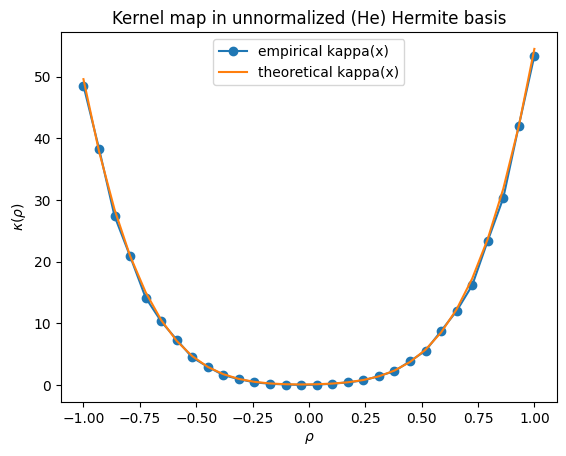

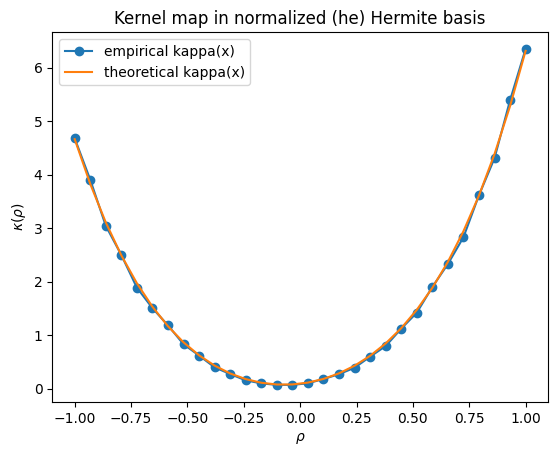

In [29]:

def kernel_map_emp(f, num_bins=100, num_samples=10**6,atol=1e-2,rtol=1e-2):
    rhos = np.linspace(-1,1,num_bins)
    vals = np.zeros(len(rhos))
    (x,y,z) = np.random.randn(3,num_samples)
    for i,rho in enumerate(rhos):
        ryz = np.sqrt(abs(rho))
        rxz = np.sign(rho) * ryz
        r = np.sqrt(1-abs(rho))
        X = rxz * z + r * y
        Y = ryz * z + r * x
        # test if rho = E[X Y], and variances are 1
        assert(np.allclose(np.mean(X * Y),rho,atol=atol,rtol=rtol))
        assert(np.allclose(np.var(X),1,atol=atol,rtol=rtol))
        assert(np.allclose(np.var(Y),1,atol=atol,rtol=rtol))
        vals[i] = np.mean(f(X) * f(Y))
    @njit
    def kernel(x):
        closest_indices = np.abs(rhos[:, np.newaxis] - x).argmin(axis=0)
        return vals[closest_indices]
    
    return kernel


# compute kernel map from Hermite coefficients
def kernel_map(coefs,r=0, norm=True):
    # cross terms dissapear, since E[He_k He_l] = 0 for k != l, leaving squared terms 
    coefs = coefs ** 2
    # if not normalized, E[He_k^2] = k!, if normalized E[He_k^2] = 1
    if not norm:
        c = 1
        for k in range(1,len(coefs)):
            c *= k
            coefs[k] = coefs[k] * c
    coefs = coefs_derivative(coefs, r)
    def kappa(x):
        return np.sum([(coefs[k]) * x**k for k in range(len(coefs))], axis=0)
    return kappa


def test_kernel_map_from_coefs(coefs, norm, atol=1e-2, rtol=1e-2, plot=True):
    f = hermite_expansion(coefs, norm=norm)
    kernel_emp = kernel_map_emp(f)
    kernel_theory = kernel_map(coefs, norm=norm)
    x = np.linspace(-1,1,30)
    emp = kernel_emp(x)
    theory = kernel_theory(x)
    if plot:
        plt.figure()
        plt.plot(x, kernel_emp(x), label='empirical kappa(x)',marker='o')
        plt.plot(x, kernel_theory(x), label='theoretical kappa(x)')
        plt.xlabel('$\\rho$')
        plt.ylabel('$\\kappa(\\rho)$')
        plt.title(f'Kernel map in {"normalized (he)" if norm else "unnormalized (He)"} Hermite basis')
        plt.legend()
    if not np.allclose(emp, theory, atol=atol, rtol=rtol):
        print("Success: Kernel map theory and empirical values are close")
    else:
        print("Failed: Kernel map theory and empirical values are not close")


def test_kernel_map_properties_from_coefs(coefs,norm, num_samples=10**7,atol=1e-2, rtol=1e-2):
    f = hermite_expansion(coefs, norm=norm)
    kappa = kernel_map(coefs, norm=norm)
    kappa_prime = kernel_map(coefs, r=1, norm=norm)
    X = np.random.randn(num_samples)
    c0 = coefs[0]
    c1 = coefs[1]
    if norm:
        c2_sum = np.sum(coefs**2)
    else:
        c2_sum = np.sum([factorial(k) * c**2 for k,c in enumerate(coefs)])
    Ef = np.mean(f(X))
    Efx = np.mean(X * f(X))
    Ef2 = np.mean(f(X)**2)
    k0 = kappa(0)
    kprime_0 = kappa_prime(0)
    k1 = kappa(1)
    np.testing.assert_allclose(c0, Ef, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c0**2, k0, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c1, Efx, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c1**2, kprime_0, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c2_sum, Ef2, atol=atol,rtol=rtol)
    np.testing.assert_allclose(c2_sum, k1, atol=atol,rtol=rtol)
    print(f"Success: Kernel map properties in {'normalized (he)' if norm else 'unnormalized (He)'} basis are satisfied")


coefs = np.random.randn(5)
print(f"testing $f(x) ={''.join(f'{' +' if c>=0 else ' -'}{abs(c):.1f} He_{i}(x)' for i,c in enumerate(coefs))}$")
test_kernel_map_from_coefs(coefs, norm=False)
test_kernel_map_properties_from_coefs(coefs, norm=False)
print(f"testing $f(x) ={''.join(f'{' +' if c>=0 else ' -'}{abs(c):.1f} he_{i}(x)' for i,c in enumerate(coefs))}$")
test_kernel_map_from_coefs(coefs, norm=True)
test_kernel_map_properties_from_coefs(coefs, norm=True)


f(x)= +0.0 he_0(x) +0.4 he_1(x) +0.9 he_2(x)
k(0) = 0.0000, k'(1) = 1.8351, k'(rho*) = 0.1649, k'(0) = 0.1649
case 1
f(x)= +0.8 he_0(x) -0.2 he_1(x) +0.6 he_2(x)
k(0) = 0.6282, k'(1) = 0.6923, k'(rho*) = 0.6923, k'(0) = 0.0513
case 2
f(x)= +0.7 he_0(x) +0.0 he_1(x) +0.7 he_2(x)
k(0) = 0.5000, k'(1) = 1.0000, k'(rho*) = 0.9955, k'(0) = 0.0000
case 3
f(x)= +0.4 he_0(x) +0.4 he_1(x) +0.8 he_2(x)
k(0) = 0.1667, k'(1) = 1.5000, k'(rho*) = 0.5000, k'(0) = 0.1667
case 4


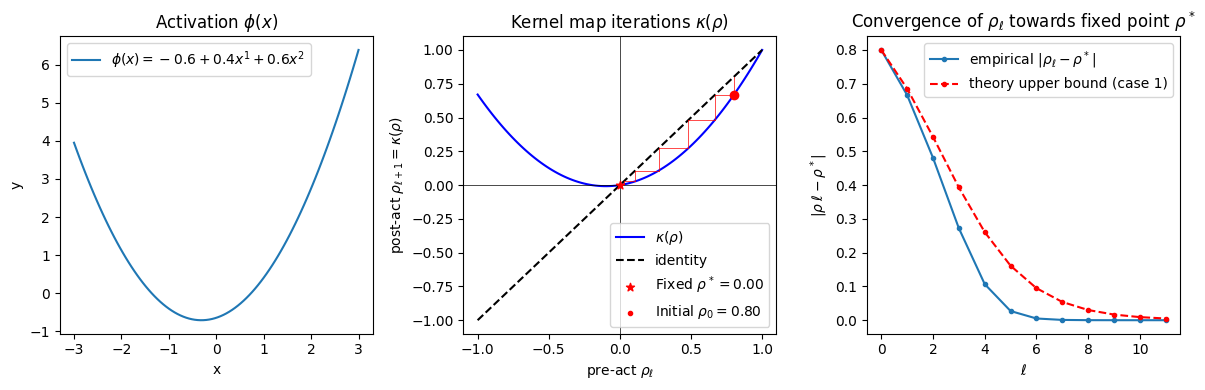

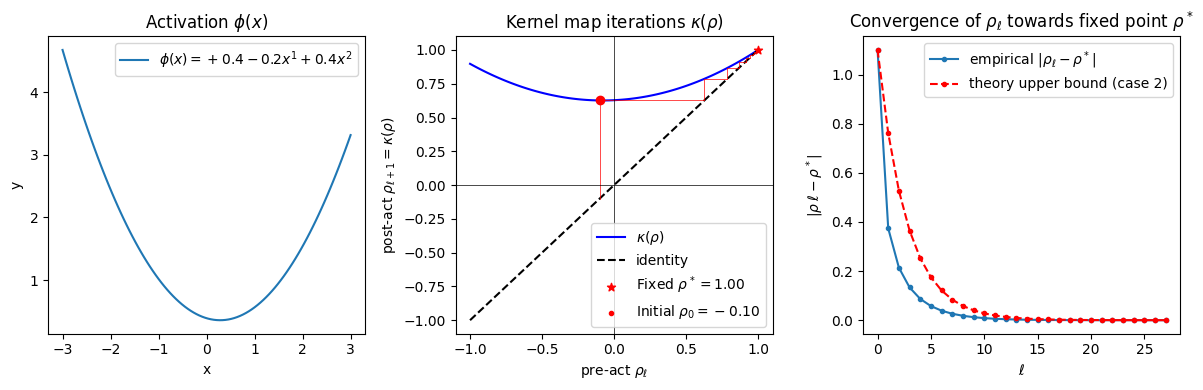

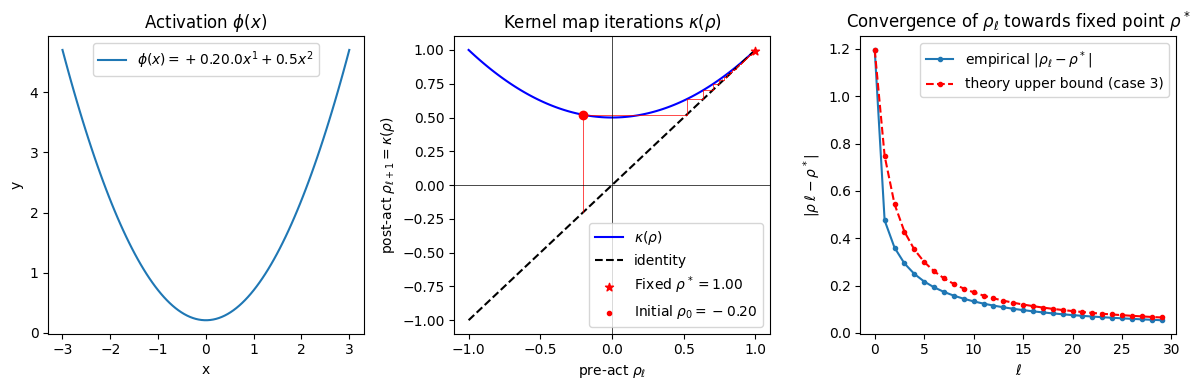

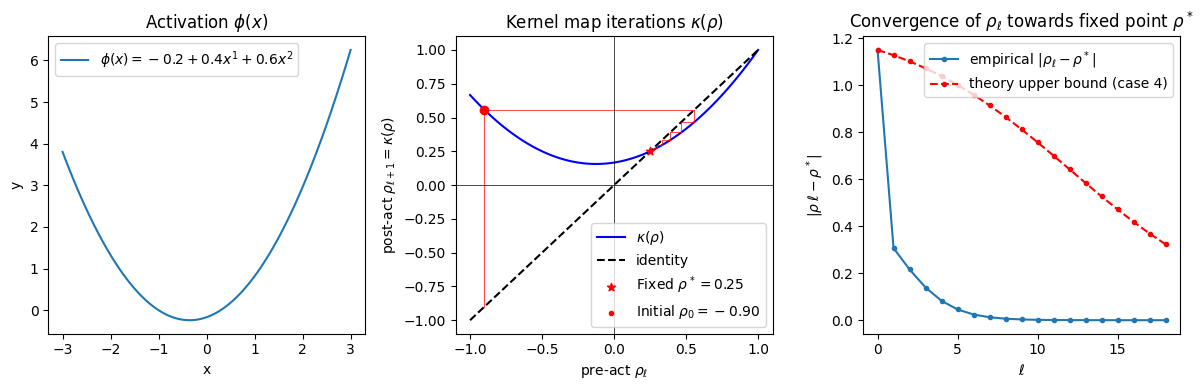

In [275]:


def fixed_point_iteration(func, rho0, eps=1e-5, max_iterations=1000):
    x_values = [rho0]
    for _ in range(max_iterations):
        x_values.append(func(x_values[-1]))
        if len(x_values)>10 and abs(x_values[-1] - x_values[-2]) < eps:
            break
    return x_values

def plot_fixed_point_iteration(func, rho0, a = 0, b=1, eps=1e-5, max_iterations=1000, kernel_name='\\kappa(\\rho)'):
    x_values = fixed_point_iteration(func, rho0, eps=eps, max_iterations=max_iterations)
    x = np.linspace(a, b, 100)
    
    plt.plot(x, func(x), label=f'${kernel_name}$', color='blue')
    plt.plot(x, x, label='identity', color='black', linestyle='--')
    
    for i in range(1, len(x_values)):
        plt.plot([x_values[i-1], x_values[i-1]], [x_values[i-1], x_values[i]], 'r',linewidth=0.5)
        plt.plot([x_values[i-1], x_values[i]], [x_values[i], x_values[i]], 'r',linewidth=0.5)
        
    plt.scatter(x_values[-1], x_values[-1], marker='*', color='red', zorder=5, label=f'Fixed $\\rho^*={x_values[-1]:.2f}$')
    plt.scatter(x_values[0], func(x_values[0]), marker='.',color='red', zorder=5, label=f'Initial $\\rho_0={rho0:.2f}$')

    plt.axhline(0, color='black',linewidth=0.5)  # Add x-axis
    plt.axvline(0, color='black',linewidth=0.5)  # Add y-axis
    
    plt.scatter(x_values[0], func(x_values[0]), color='red', zorder=5)
    plt.title(f'Kernel map iterations $\\kappa(\\rho)$')
    plt.xlabel('pre-act $\\rho_\\ell$')
    plt.ylabel('post-act $\\rho_{\\ell+1}=\\kappa(\\rho)$')
    # plt.grid(True)
    plt.legend()
    plt.tight_layout()




def convergence_bound(kappa, kappa_prime, rho0,eps=1e-4):
    rhos = fixed_point_iteration(kappa, rho0=rho0)
    rho_star = rhos[-1]
    rhos = rhos[:30]
    ls = np.arange(len(rhos))


    k0 = kappa(0)
    k_prime_star = kappa_prime(rho_star)
    k_prime_1 = kappa_prime(1)
    k_prime_0 = kappa_prime(0)

    print(f"k(0) = {k0:.4f}, k'(1) = {k_prime_1:.4f}, k'(rho*) = {k_prime_star:.4f}, k'(0) = {k_prime_0:.4f}")

    if abs(k0) < eps: # instead of 0, to avoid numerical issues
        case = ('case 1')
        x0 = abs(rho0-rho_star)
        # alpha =  np.exp(-ls*(1-k_prime_0))
        # bound = (x0 * alpha ) / (1-x0 + x0 * alpha )
        alpha = (1.0/k_prime_1)
        alpha = 1/(2-k_prime_0)
        bound = x0 * alpha **ls / (1-x0 + x0 * alpha**ls)
    else:
        if k_prime_1 < 1-eps: # k_prime_1 < 1
            case = ('case 2')
            alpha = (k_prime_1)
            bound = abs(rho0-rho_star) * alpha **ls
        elif abs(k_prime_1-1) < eps: # k_prime_1 = 1
            case = ('case 3')
            alpha = k0+k_prime_0
            bound = abs(rho0-rho_star) / (ls * (1-alpha) * abs(rho0-rho_star) + 1)
        else: # k_prime_1 > 1
            case = ('case 4')
            alpha1 = (1-rho_star)/(2-k_prime_star)
            alpha2 = k_prime_star
            alpha3 = 1-k0
            alpha = max([alpha1,alpha2,alpha3])
            bound = (abs(rho0-rho_star) * alpha**ls) / (1 - abs(rho0) + abs(rho0) * alpha**ls)

    print(case)
    # print(f"alpha = {alpha:.4f}, rho* = {rho_star:.4f}, k'* = {k_prime_star:.4f}, k0 = {k0:.4f}")
    l = np.arange(len(rhos))
    plt.plot(np.abs(rhos-rho_star), marker='.',label='empirical $|\\rho_\\ell - \\rho^*|$')
    plt.plot(bound, '--', color='red',marker='.',label=f'theory upper bound ({case})')
    plt.ylabel('$|\\rho_ \\ell-\\rho^*|$')
    plt.xlabel('$\\ell$')
    plt.title('Convergence of $\\rho_\\ell$ towards fixed point $\\rho^*$')
    plt.legend()
    # plt.yscale('log')
    plt.tight_layout()

def plot_activation(f, act_name, a=-3,b=3):
    x = np.linspace(a,b,100)
    plt.plot(x,f(x), label=f'${act_name}$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Activation $\\phi(x)$')
    plt.legend()
    plt.tight_layout()

def coefs2name(poly_coefs):
    def sgn(c):
        if c==0:
            return ''
        if c>0:
            return '+'
        else:
            return '-'
    act_name = (f"\\phi(x)={''.join(f'{sgn(c)}{abs(c):.1f}{f"x^{i}" if i>0 else ""}' for i,c in enumerate(poly_coefs))}")
    return act_name 

def coefs2kernel_name(coefs):
    def term(c,i):
        if c==0:
            return ''
        elif i==0:
            return f'+{c:.1f}'
        else:
            return f'+{c:.1f}\\rho^{i}'
    kernel_name = (f"\\kappa(\\rho) ={''.join(term(c**2,i) for i,c in enumerate(coefs))}")
    return kernel_name


all_coefs = [(.8, [0,.4,.9,]),(-.1, [.7,-.2, .5, ]), (-.2,[1,0,1]), (-.9,[.5, .5, 1.,])]
coefs = np.array([1,0,1])
rho0=np.random.rand()*2-1
coefs = np.random.randn(3)
if np.random.rand()<0.2:
    coefs[0] = 0
for n in range(4):
    rho0, coefs = all_coefs[n]
    coefs = np.array(coefs)
    coefs = coefs / np.sum(coefs**2)**0.5
    f, poly_coefs = hermite_expansion(coefs, return_coefs=True)

    act_name = coefs2name(poly_coefs)
    print(f"f(x)={''.join(f'{' +' if c>=0 else ' -'}{abs(c):.1f} he_{i}(x)' for i,c in enumerate(coefs))}")

    kernel_name = coefs2kernel_name(coefs)
    kernel_name = '\\kappa(\\rho)'

    kappa = kernel_map(coefs)
    kappa_prime = kernel_map(coefs,1)

    plt.figure(figsize=(12,4))
    plt.subplot(1, 3, 1)
    plot_activation(f, act_name)
    plt.tight_layout()
    plt.subplot(1, 3, 3)
    convergence_bound(kappa, kappa_prime, rho0, eps=1e-2)
    plt.subplot(1, 3, 2)
    plot_fixed_point_iteration(kappa, rho0, -1,1, kernel_name=kernel_name)
    plt.savefig(f'images/kernel_map_convergence_case_{n}.pdf')

Mean Absolute Error = 0.01438


/var/folders/zn/c_3kf_gx42n9mqlw1f1qh4rc0000gn/T/ipykernel_22278/2086187828.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


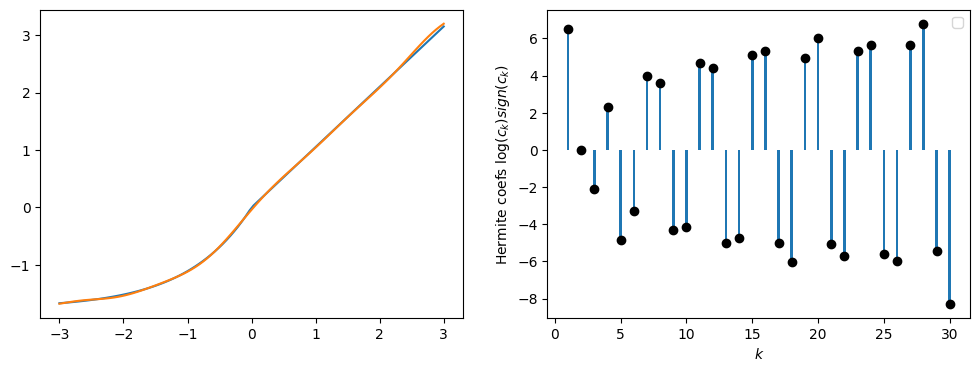

In [223]:

f = get_activation_function('selu',)
coefs = compute_hermite_coefs(f, coefs_len=30,num_samples=10**6)
f2 = hermite_expansion(coefs)
x = np.linspace(-3,3,100)
mae = np.mean(abs(f(x)-f2(x)))
print(f"Mean Absolute Error = {mae:.5f}")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(x,f(x), label='original')
plt.plot(x,f2(x), label='recovered')
plt.subplot(1,2,2)
sg = np.sign(coefs)
scoefs = np.log(np.abs(coefs)) * sg
plt.bar(range(1,len(coefs)+1),scoefs,width=0.2)
plt.scatter(range(1,len(coefs)+1),scoefs,marker='o',color='k',)
plt.ylabel('Hermite coefs $\\log(c_k) sign(c_k)$')
plt.xlabel('$k$')
plt.legend()

k(0) = 0.0000, k'(1) = 1.1773, k'(rho*) = 0.9306, k'(0) = 0.9306
case 1
k(0) = 0.3182, k'(1) = 0.9410, k'(rho*) = 0.9409, k'(0) = 0.5005
case 2
k(0) = 0.3686, k'(1) = 0.9945, k'(rho*) = 0.9930, k'(0) = 0.3684
case 3
k(0) = 0.1870, k'(1) = 1.0721, k'(rho*) = 0.9326, k'(0) = 0.5879
case 4


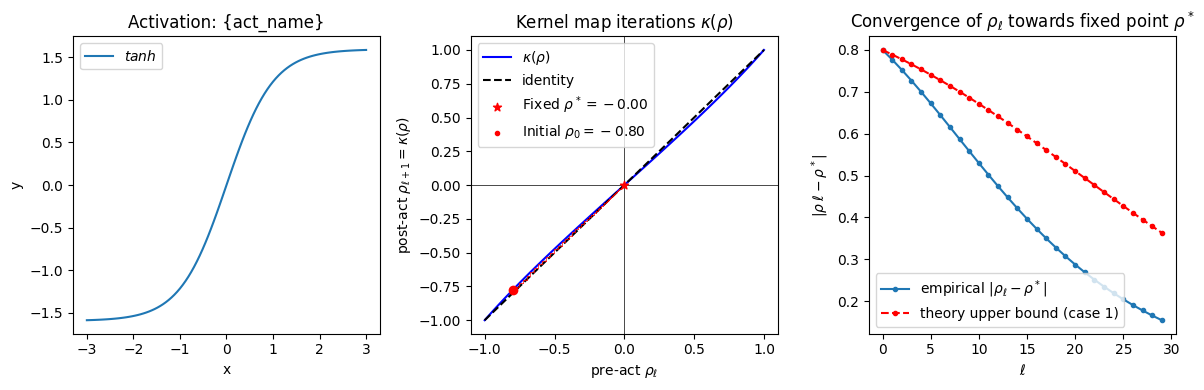

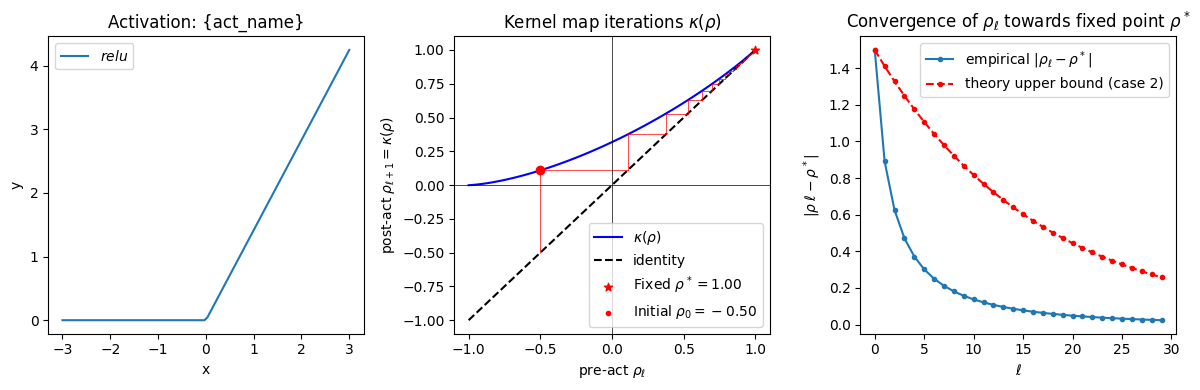

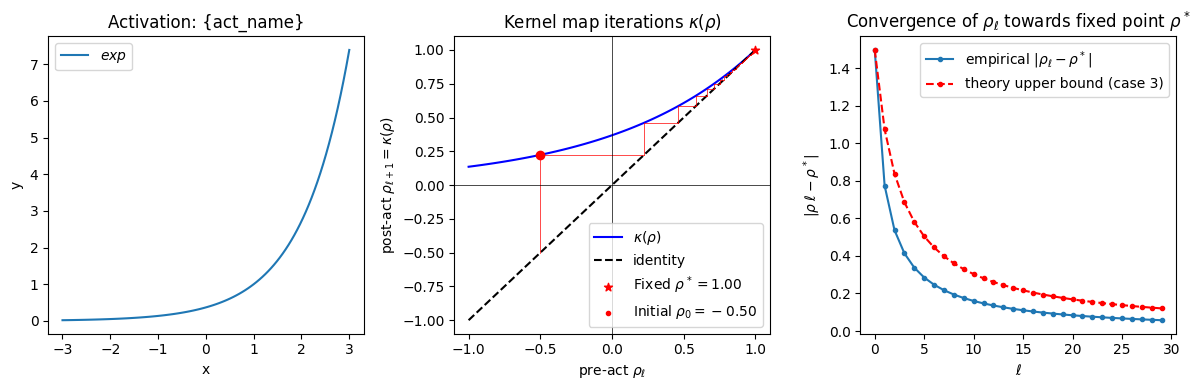

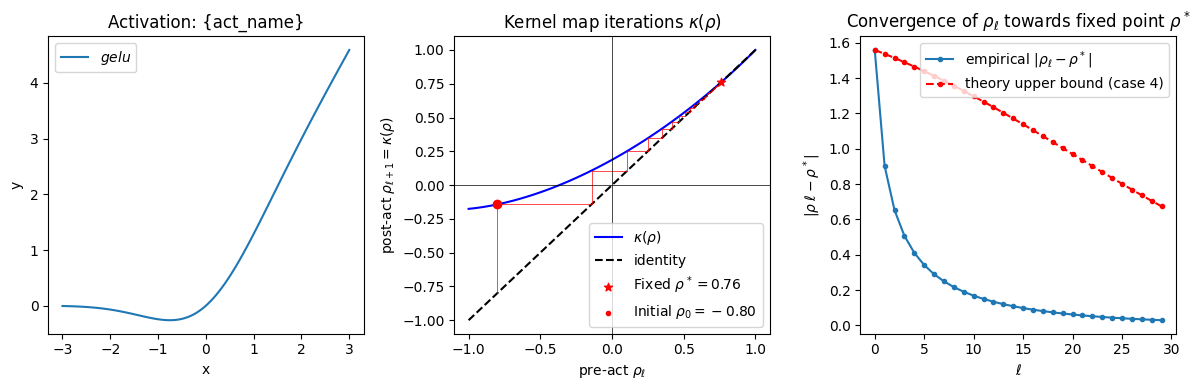

In [293]:
def plot_activation(f, act_name, a=-3,b=3):
    x = np.linspace(a,b,100)
    plt.plot(x,f(x), label=f'${act_name}$')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Activation: {act_name}')
    plt.legend()
    plt.tight_layout()

all_coefs = [(-.8, 'tanh'), (-.5, 'relu'), (-.5, 'exp'), (-.8, 'gelu')]
for n in range(4):
    rho0, act_name = all_coefs[n]
    f = get_activation_function(act_name)
    C = np.mean(f(np.random.randn(10**7))**2)**0.5
    coefs = compute_hermite_coefs(f, order=20, num_samples=10**7)
    coefs = coefs / np.sum(coefs**2)**0.5
    f_norm = lambda x: f(x)/C
    # act_name = f'\\propto {act_name}(x)'

    kernel_name = coefs2kernel_name(coefs)
    kernel_name = '\\kappa(\\rho)'

    kappa = kernel_map(coefs)
    kappa_prime = kernel_map(coefs,1)

    plt.figure(figsize=(12,4))
    plt.subplot(1, 3, 1)
    plot_activation(f_norm, act_name=f'{act_name}', a=-3,b=3)
    plt.tight_layout()
    plt.subplot(1, 3, 3)
    convergence_bound(kappa, kappa_prime, rho0, eps=1e-2)
    plt.subplot(1, 3, 2)
    plot_fixed_point_iteration(kappa, rho0, -1,1, kernel_name=kernel_name)
    plt.savefig(f'images/kernel_map_convergence_case_{n}_{act_name}.pdf')

We have the multiplication and addition theorem 
$$
\begin{align}
&He_n(x+y) = \sum_{k=0}^n \binom{n}{k}x^{n-k} He_k(y) \\
&He_n(\gamma x) = \sum_{i=0}^{\lfloor \frac{n}{2} \rfloor} \gamma^{n-2i} (\gamma^2 - 1)^i \binom{n}{2i} \frac{(2i)!}{i!} 2^{-i} He_{n-2i}(x).
\end{align}
$$


In [ ]:
from scipy.special import comb, factorial

def he_add_weights(n, gamma):
    # Initialize a vector of length n+1 to store the weights
    weights = np.zeros(n + 1)

    # Iterate over the terms in the sum
    for k in range(n // 2 + 1):
        weights[k] =  comb(n, k) *  x ** (n-k)
    
    return weights

def he_mult_weights(n, gamma):
    # Initialize a vector of length n+1 to store the weights
    weights = np.zeros(n + 1)

    # Iterate over the terms in the sum
    for i in range(n // 2 + 1):
        coeff = (gamma**(n - 2 * i)) * ((gamma**2 - 1)**i) * comb(n, 2 * i) * (factorial(2 * i) / (factorial(i) * 2**i))
        weights[n - 2 * i] += coeff
    
    return weights

# Example usage:
n = 2  # Degree of Hermite polynomial
gamma = 1.5  # Value of gamma
weights = he_mult_weights(n, gamma)
print(f"Weights vector for n={n} and gamma={gamma}:\n", weights)

He = [hermite_poly(k,norm=False) for k in range(n+1)]

x = np.array([1,2,-1,-2])
y = He[n](gamma * x)
y2 = weights @ np.array([He[k](x) for k in range(n+1)])
y, y2

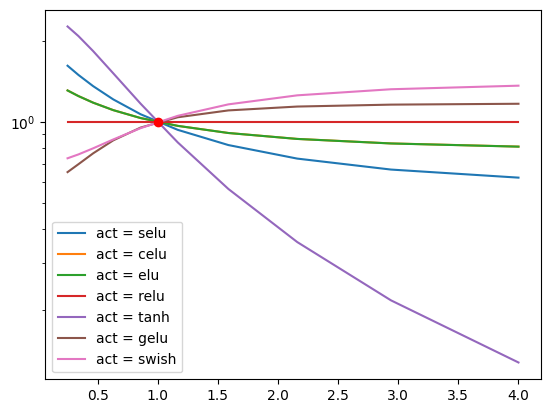

In [435]:
coefs = np.array([4**(-i)*(1 if i%4 in [0,1,] else -1) for i in range(20)])
coefs = coefs / np.sum(coefs**2)**0.5
f = hermite_expansion(coefs)
for act in ['selu', 'celu', 'elu', 'relu', 'tanh','gelu','swish',]:
    f = get_activation_function(act) 
    x = np.linspace(-5,5,100)
    gamma = 2**np.linspace(-2,2,10)
    X = np.random.randn(10**6)
    vals = np.zeros(len(gamma))
    for i,g in enumerate(gamma):
        vals[i] = np.mean(f(g*X)**2)/np.mean(f(X)**2)/g**2
    plt.plot(gamma,vals,label=f'act = {act}')
plt.legend()
plt.plot([1],[1],'ro')
plt.yscale('log')
# np.mean()


tanh: -0.3934
selu: -0.2436
celu: -0.0988
elu: -0.0987
swish: 0.0894
gelu: 0.1069
relu: 0.1465


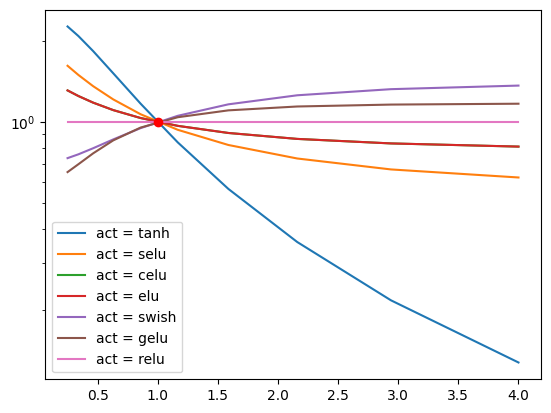

In [24]:
slopes = []
for act in ['selu', 'celu', 'elu', 'relu', 'tanh','gelu','swish',]:
    f = get_activation_function(act)
    coefs = compute_hermite_coefs(f, coefs_len=20,num_samples=10**7,norm=False)
    coefs = coefs / np.sum(coefs**2)**0.5
    coefs2 = coefs_derivative(coefs,2)
    f2 = hermite_expansion(coefs2)
    X = np.random.randn(10**7)
    slopes.append((np.mean(f2(X)*f(X)),act))
slopes = sorted(slopes)
for s,a in slopes:
    print(f'{a}: {s:.4f}')


acts = [a for s,a in slopes]
for act in acts:
    f = get_activation_function(act) 
    x = np.linspace(-5,5,100)
    gamma = 2**np.linspace(-2,2,10)
    X = np.random.randn(10**6)
    vals = np.zeros(len(gamma))
    for i,g in enumerate(gamma):
        vals[i] = np.mean(f(g*X)**2)/np.mean(f(X)**2)/g**2
    plt.plot(gamma,vals,label=f'act = {act}')
plt.legend()
plt.plot([1],[1],'ro')
plt.yscale('log')


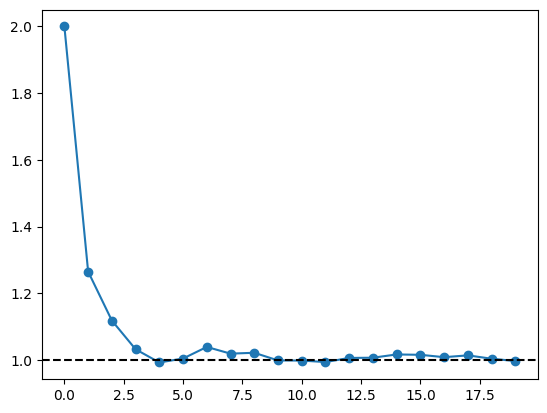

In [434]:
# norm stability 
f = get_activation_function('tanh')
f_norm = np.mean(f(np.random.randn(10**7))**2)
L = 20
gamma = 2
gammas = np.zeros(L)
for l in range(L):
    X = np.random.randn(10**3)
    gammas[l] = gamma
    gamma = (np.mean(f(gamma*X)**2)/f_norm) ** 0.5
plt.plot((gammas),marker='o')
plt.axhline(y=1,color='k',linestyle='--')



Weights vector for n=2 and gamma=1.5:
 [1.25 0.   2.25]


(array([1.25, 8.  , 1.25, 8.  ]), array([1.25, 8.  , 1.25, 8.  ]))

slope = 0.3965


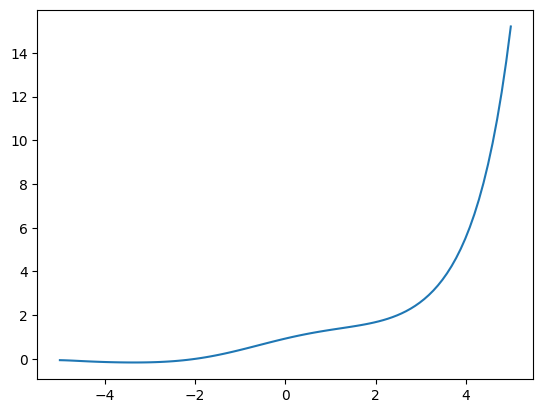

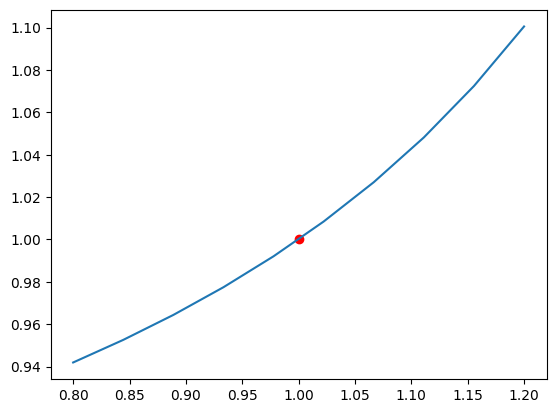

In [254]:



# degree = k
# x_values = np.linspace(-1, 1, 100)
# hermite_values = hermite_polynomial(x_values, degree)

# plt.plot(x_values, hermite_values)
# plt.xlabel('x')
# plt.ylabel(f'Hermite Polynomial of Degree {degree}')
# plt.title(f'Hermite Polynomial of Degree {degree}')
# plt.grid(True)
# plt.show()

coefs = np.array([(1 if i%4 in [0,1] else 0)**i * 2**(-i) for i in range(10)])
coefs = coefs / np.sum(coefs**2)**0.5
def f(x):
    H = [hermite_poly(k) for k in range(len(coefs))]
    return np.sum([c * H[k](x) for k,c in enumerate(coefs)], axis=0)

X = np.random.randn(1000)
c2 = np.mean(f(X)**2) ** 0.5
def f_norm(x):
    return f(x)/c2

gamma = np.linspace(.8,1.2,10)
f_norms = []
for g in gamma:
    f_norms.append(np.mean(f_norm(X*g)**2))

slope = (f_norms[-1]-f_norms[0])/(gamma[-1]-gamma[0])
print(f"slope = {slope:.4f}")

plt.figure()
x = np.linspace(-5,5,100)
plt.plot(x, f_norm(x))

plt.figure()
plt.plot(gamma, f_norms)
plt.scatter([1],[1], color='red')

In [293]:
f = get_activation_function('sigmoid')
X = np.random.randn(10**7)
a = .5
np.mean(f(X * a)**2) / np.mean(f(X)**2), a**2


(0.8996665307506756, 0.25)

In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.nn import RMSNorm


# Define the custom activation module
class CustomActivation(nn.Module):
    def __init__(self, activation_fn):
        super(CustomActivation, self).__init__()
        self.activation_fn = activation_fn  # Store the custom activation function

    def forward(self, x):
        return self.activation_fn(x)  # Apply the custom function to the input


# Define the MLP class
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, activation_fn):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation_fn)
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation_fn)
            layers.append(RMSNorm(hidden_dim))
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    


# Training the model
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.view(-1, 32 * 32 * 3).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')
        test(model, test_loader)

# Testing the model
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(-1, 32 * 32 * 3).to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')



# Custom activation function (example: Leaky ReLU)
activation_fn = nn.LeakyReLU()

# Hyperparameters
input_dim = 32 * 32 * 3  # CIFAR-10 images are 32x32x3
hidden_dim = 256  # You can change this to your desired hidden dimension
output_dim = 10   # 10 classes in CIFAR-10
num_layers = 30    # You can change the number of hidden layers
num_epochs = 10
batch_size = 50
learning_rate = 0.001

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize between -1 and 1
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def f(x):
    return torch.exp(x) +  x * num_layers**0.5
f = nn.SELU()
activation_fn = CustomActivation(f)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, activation_fn=activation_fn).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


# Train and test the model
train(model, train_loader, criterion, optimizer, num_epochs)
# test(model, test_loader)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 1.8307
Test Accuracy: 38.48%
Epoch [2/10], Loss: 1.7244
Test Accuracy: 39.71%
Epoch [3/10], Loss: 1.6820
Test Accuracy: 40.29%
Epoch [4/10], Loss: 1.6501
Test Accuracy: 41.82%
Epoch [5/10], Loss: 1.6219
Test Accuracy: 41.85%
Epoch [6/10], Loss: 1.5982
Test Accuracy: 41.60%
Epoch [7/10], Loss: 1.5757
Test Accuracy: 43.31%
Epoch [8/10], Loss: 1.5564
Test Accuracy: 43.62%
Epoch [9/10], Loss: 1.5382
Test Accuracy: 44.66%
Epoch [10/10], Loss: 1.5187
Test Accuracy: 44.14%


In [175]:

def f(x):
    return torch.exp(x) +  x * num_layers**0.5
activation_fn = CustomActivation(f)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, activation_fn=activation_fn).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


# Train and test the model
train(model, train_loader, criterion, optimizer, num_epochs=20)
# test(model, test_loader)

Epoch [1/10], Loss: 1.7987
Test Accuracy: 41.51%
Epoch [2/10], Loss: 1.5801
Test Accuracy: 45.53%
Epoch [3/10], Loss: 1.4919
Test Accuracy: 47.23%
Epoch [4/10], Loss: 1.4293
Test Accuracy: 48.11%
Epoch [5/10], Loss: 1.3795
Test Accuracy: 48.90%
Epoch [6/10], Loss: 1.3322
Test Accuracy: 48.96%
Epoch [7/10], Loss: 1.2936
Test Accuracy: 50.29%
Epoch [8/10], Loss: 1.2581
Test Accuracy: 50.41%
Epoch [9/10], Loss: 1.2239
Test Accuracy: 50.35%
Epoch [10/10], Loss: 1.1953
Test Accuracy: 50.26%
